# Insects CNN

## Step 1 - Import Libraries

In [39]:
import warnings
warnings.simplefilter("ignore")

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split, DataLoader

import torchvision
from torchvision import datasets, transforms
torch.manual_seed(0)

In [41]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

In [42]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
print("PyTorch version:", torch.__version__)
# use cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

PyTorch version: 2.5.1
device: cpu


In [44]:
from lime import lime_image

In [45]:
import matplotlib.cm as cm

In [46]:
import shap

In [47]:
from skimage.segmentation import mark_boundaries

In [48]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

## Step 2 - Load the dataset

> Sample pictures colected from [https://www.insectimages.org/](https://www.insectimages.org/)

> Credits to https://github.com/MTang0728/SimpleCNN-with-SHAP/

In [49]:
DATA_ROOT = "/Users/brusnto/Doutorado/XAI/ProjetoFinal/datasets/insects"
BATCH_SIZE = 64

In [50]:
transform_image_resize = transforms.Compose([
    transforms.Resize(size = (224, 224)),
    transforms.ToTensor(),
])

In [51]:
train_ds = datasets.ImageFolder(
    f"{DATA_ROOT}/train/",
    transform=transform_image_resize
)
test_ds = datasets.ImageFolder(
    f"{DATA_ROOT}/test/",
    transform=transform_image_resize
)

print(type(train_ds))

<class 'torchvision.datasets.folder.ImageFolder'>


In [52]:
CLASS_TO_IDX_MAP = train_ds.class_to_idx
CLASS_NAMES = list(CLASS_TO_IDX_MAP.keys())
N_CLASSES = len(CLASS_NAMES)

CLASS_TO_IDX_MAP

{'beetles': 0, 'cockroach': 1, 'dragonflies': 2}

In [53]:
def get_class_names_from_idxs(idx_list):
    idx_to_class_map = {v: k for k, v in CLASS_TO_IDX_MAP.items()}

    if type(idx_list) == int or type(idx_list) == np.int64:
        idx_list = [idx_list]
    
    if type(idx_list) == torch.Tensor:
        if idx_list.dim() == 0:
            idx_list = [int(idx_list.item())]
        else:
            idx_list = [int(t.item()) for t in idx_list]
    
    return [idx_to_class_map[idx] for idx in idx_list]

In [54]:
train_size = int(0.8 * len(train_ds))
val_size = len(train_ds) - train_size
train_ds, val_ds = random_split(train_ds, [train_size, val_size])

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True
)
val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=True
)
test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=True
)
print(type(train_loader))

<class 'torch.utils.data.dataloader.DataLoader'>


In [55]:
images, targets = next(iter(train_loader))

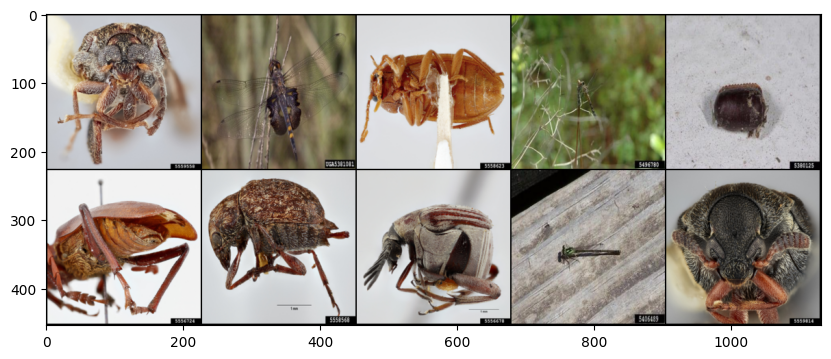

<class 'torch.Tensor'>


In [56]:
images = images[:10]
targets = targets[:10]
grid_img = torchvision.utils.make_grid(images, 5)

%matplotlib inline
plt.figure(figsize = (10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()
print(type(images))

## Step 3 - Implement CNN

In [57]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_section = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=5),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.fc_section = nn.Sequential(
            nn.Linear(16 * 54 * 54, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, N_CLASSES)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        conv_out = self.conv_section(x)
        flatten_out = conv_out.reshape(x.size(0), -1)  # Optimize for batch dimension
        return self.fc_section(flatten_out)

## Step 4 - Train CNN

In [58]:
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=1e-3)

train_metrics = {'loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []}
val_metrics = {'loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []}

In [59]:
model_save_path = "models/insects_CNN.pth"

In [60]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_train, correct_train, train_loss = 0, 0, 0.0
    all_train_preds, all_train_labels = [], []

    for inputs, targets in tqdm(train_loader, desc="Training", leave=False):
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track accuracy and loss
        _, preds = torch.max(outputs, 1)
        correct_train += preds.eq(targets).sum().item()
        total_train += targets.size(0)
        train_loss += loss.item()

        # Collect predictions and labels for metric calculation
        all_train_preds.extend(preds.cpu().numpy())
        all_train_labels.extend(targets.cpu().numpy())

    # Calculate metrics
    accuracy = correct_train / total_train
    precision = precision_score(all_train_labels, all_train_preds, average="weighted")
    recall = recall_score(all_train_labels, all_train_preds, average="weighted")
    f1 = f1_score(all_train_labels, all_train_preds, average="weighted")
    avg_loss = train_loss / len(train_loader)

    return avg_loss, accuracy, precision, recall, f1

def evaluate(model, val_loader, criterion, device, print_cf_report=False):
    model.eval()
    total_val, correct_val, val_loss = 0, 0, 0.0
    all_val_preds, all_val_labels = [], []

    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc="Validating", leave=False):
            inputs, targets = inputs.to(device), targets.to(device)

            # Compute outputs and loss
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Track accuracy and loss
            _, preds = torch.max(outputs, 1)
            correct_val += preds.eq(targets).sum().item()
            total_val += targets.size(0)
            val_loss += loss.item()

            # Collect predictions and labels for metric calculation
            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(targets.cpu().numpy())

    # Calculate metrics
    accuracy = correct_val / total_val
    precision = precision_score(all_val_labels, all_val_preds, average="weighted")
    recall = recall_score(all_val_labels, all_val_preds, average="weighted")
    f1 = f1_score(all_val_labels, all_val_preds, average="weighted")
    avg_loss = val_loss / len(val_loader)

    if print_cf_report:
        print(classification_report(all_val_labels, all_val_preds))

    return avg_loss, accuracy, precision, recall, f1

In [61]:
EPOCHS = 50
PATIENCE = 5

best_val_loss = float('inf')
early_stop_counter = 0

print("==> Training starts!")
print("=" * 50)

# Training loop with validation and early stopping
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    
    # Train for one epoch
    train_loss, train_accuracy, train_precision, train_recall, train_f1 = train_one_epoch(
        model, train_loader, criterion, optimizer, device
    )
    print(f"Training Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1-Score: {train_f1:.4f}")

    train_metrics['loss'].append(train_loss)
    train_metrics['accuracy'].append(train_accuracy)
    train_metrics['precision'].append(train_precision)
    train_metrics['recall'].append(train_recall)
    train_metrics['f1_score'].append(train_f1)
    
    # Validate on validation set
    val_loss, val_accuracy, val_precision, val_recall, val_f1 = evaluate(
        model, val_loader, criterion, device
    )
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1-Score: {val_f1:.4f}\n")

    val_metrics['loss'].append(val_loss)
    val_metrics['accuracy'].append(val_accuracy)
    val_metrics['precision'].append(val_precision)
    val_metrics['recall'].append(val_recall)
    val_metrics['f1_score'].append(val_f1)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0  # Reset counter if there is an improvement
    else:
        early_stop_counter += 1
        print(f"Early stopping counter: {early_stop_counter}/{PATIENCE} \n")

    if early_stop_counter >= PATIENCE:
        print("Early stopping triggered. \n")
        break

print("==> Training complete!")

torch.save(model.state_dict(), model_save_path)
print(f"Final model saved at: {model_save_path}")

==> Training starts!
Epoch 1/50


Training Loss: 0.7650, Accuracy: 0.6618, Precision: 0.6707, Recall: 0.6618, F1-Score: 0.6188


Validation Loss: 0.9375, Accuracy: 0.6225, Precision: 0.7794, Recall: 0.6225, F1-Score: 0.6205

Epoch 2/50


Training Loss: 0.4228, Accuracy: 0.8444, Precision: 0.8443, Recall: 0.8444, F1-Score: 0.8443


Validation Loss: 0.5700, Accuracy: 0.7941, Precision: 0.8055, Recall: 0.7941, F1-Score: 0.7802

Epoch 3/50


Training Loss: 0.3047, Accuracy: 0.8799, Precision: 0.8816, Recall: 0.8799, F1-Score: 0.8800


Validation Loss: 0.7136, Accuracy: 0.6716, Precision: 0.8180, Recall: 0.6716, F1-Score: 0.6701

Early stopping counter: 1/5 

Epoch 4/50


Training Loss: 0.2235, Accuracy: 0.9326, Precision: 0.9334, Recall: 0.9326, F1-Score: 0.9328


Validation Loss: 0.6229, Accuracy: 0.7843, Precision: 0.7828, Recall: 0.7843, F1-Score: 0.7624

Early stopping counter: 2/5 

Epoch 5/50


Training Loss: 0.1531, Accuracy: 0.9534, Precision: 0.9535, Recall: 0.9534, F1-Score: 0.9535


Validation Loss: 0.3405, Accuracy: 0.8529, Precision: 0.8607, Recall: 0.8529, F1-Score: 0.8542

Epoch 6/50


Training Loss: 0.0928, Accuracy: 0.9730, Precision: 0.9735, Recall: 0.9730, F1-Score: 0.9731


Validation Loss: 0.6090, Accuracy: 0.8529, Precision: 0.8791, Recall: 0.8529, F1-Score: 0.8582

Early stopping counter: 1/5 

Epoch 7/50


Training Loss: 0.0494, Accuracy: 0.9877, Precision: 0.9878, Recall: 0.9877, F1-Score: 0.9878


Validation Loss: 0.3742, Accuracy: 0.8529, Precision: 0.8656, Recall: 0.8529, F1-Score: 0.8507

Early stopping counter: 2/5 

Epoch 8/50


Training Loss: 0.0223, Accuracy: 0.9988, Precision: 0.9988, Recall: 0.9988, F1-Score: 0.9988


Validation Loss: 0.3553, Accuracy: 0.9020, Precision: 0.9127, Recall: 0.9020, F1-Score: 0.9041

Early stopping counter: 3/5 

Epoch 9/50


Training Loss: 0.0170, Accuracy: 0.9963, Precision: 0.9963, Recall: 0.9963, F1-Score: 0.9963


Validation Loss: 0.3215, Accuracy: 0.8873, Precision: 0.8963, Recall: 0.8873, F1-Score: 0.8865

Epoch 10/50


Training Loss: 0.0082, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


Validation Loss: 0.2539, Accuracy: 0.9118, Precision: 0.9185, Recall: 0.9118, F1-Score: 0.9133

Epoch 11/50


Training Loss: 0.0046, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


Validation Loss: 0.2763, Accuracy: 0.9216, Precision: 0.9257, Recall: 0.9216, F1-Score: 0.9220

Early stopping counter: 1/5 

Epoch 12/50


Training Loss: 0.0041, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


Validation Loss: 0.2720, Accuracy: 0.9118, Precision: 0.9164, Recall: 0.9118, F1-Score: 0.9130

Early stopping counter: 2/5 

Epoch 13/50


Training Loss: 0.0027, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


Validation Loss: 0.2569, Accuracy: 0.9118, Precision: 0.9169, Recall: 0.9118, F1-Score: 0.9129

Early stopping counter: 3/5 

Epoch 14/50


Training Loss: 0.0024, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


Validation Loss: 0.2761, Accuracy: 0.9167, Precision: 0.9201, Recall: 0.9167, F1-Score: 0.9172

Early stopping counter: 4/5 

Epoch 15/50


Training Loss: 0.0020, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


Validation Loss: 0.2530, Accuracy: 0.9167, Precision: 0.9208, Recall: 0.9167, F1-Score: 0.9174

Epoch 16/50


Training Loss: 0.0018, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


Validation Loss: 0.2787, Accuracy: 0.9216, Precision: 0.9259, Recall: 0.9216, F1-Score: 0.9221

Early stopping counter: 1/5 

Epoch 17/50


Training Loss: 0.0016, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


Validation Loss: 0.3126, Accuracy: 0.9216, Precision: 0.9254, Recall: 0.9216, F1-Score: 0.9223

Early stopping counter: 2/5 

Epoch 18/50


Training Loss: 0.0016, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


Validation Loss: 0.2514, Accuracy: 0.9118, Precision: 0.9164, Recall: 0.9118, F1-Score: 0.9130

Epoch 19/50


Training Loss: 0.0016, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


Validation Loss: 0.2455, Accuracy: 0.9167, Precision: 0.9213, Recall: 0.9167, F1-Score: 0.9175

Epoch 20/50


Training Loss: 0.0014, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


Validation Loss: 0.3238, Accuracy: 0.9216, Precision: 0.9254, Recall: 0.9216, F1-Score: 0.9223

Early stopping counter: 1/5 

Epoch 21/50


Training Loss: 0.0012, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


Validation Loss: 0.2818, Accuracy: 0.9216, Precision: 0.9249, Recall: 0.9216, F1-Score: 0.9224

Early stopping counter: 2/5 

Epoch 22/50


Training Loss: 0.0013, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


Validation Loss: 0.2331, Accuracy: 0.9167, Precision: 0.9197, Recall: 0.9167, F1-Score: 0.9173

Epoch 23/50


Training Loss: 0.0011, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


Validation Loss: 0.2516, Accuracy: 0.9167, Precision: 0.9213, Recall: 0.9167, F1-Score: 0.9175

Early stopping counter: 1/5 

Epoch 24/50


Training Loss: 0.0011, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


Validation Loss: 0.2509, Accuracy: 0.9167, Precision: 0.9213, Recall: 0.9167, F1-Score: 0.9175

Early stopping counter: 2/5 

Epoch 25/50


Training Loss: 0.0010, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


Validation Loss: 0.2504, Accuracy: 0.9265, Precision: 0.9297, Recall: 0.9265, F1-Score: 0.9271

Early stopping counter: 3/5 

Epoch 26/50


Training Loss: 0.0010, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


Validation Loss: 0.4122, Accuracy: 0.9216, Precision: 0.9249, Recall: 0.9216, F1-Score: 0.9224

Early stopping counter: 4/5 

Epoch 27/50


Training Loss: 0.0009, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


Validation Loss: 0.2443, Accuracy: 0.9216, Precision: 0.9249, Recall: 0.9216, F1-Score: 0.9224

Early stopping counter: 5/5 

Early stopping triggered. 

==> Training complete!
Final model saved at: models/insects_CNN.pth


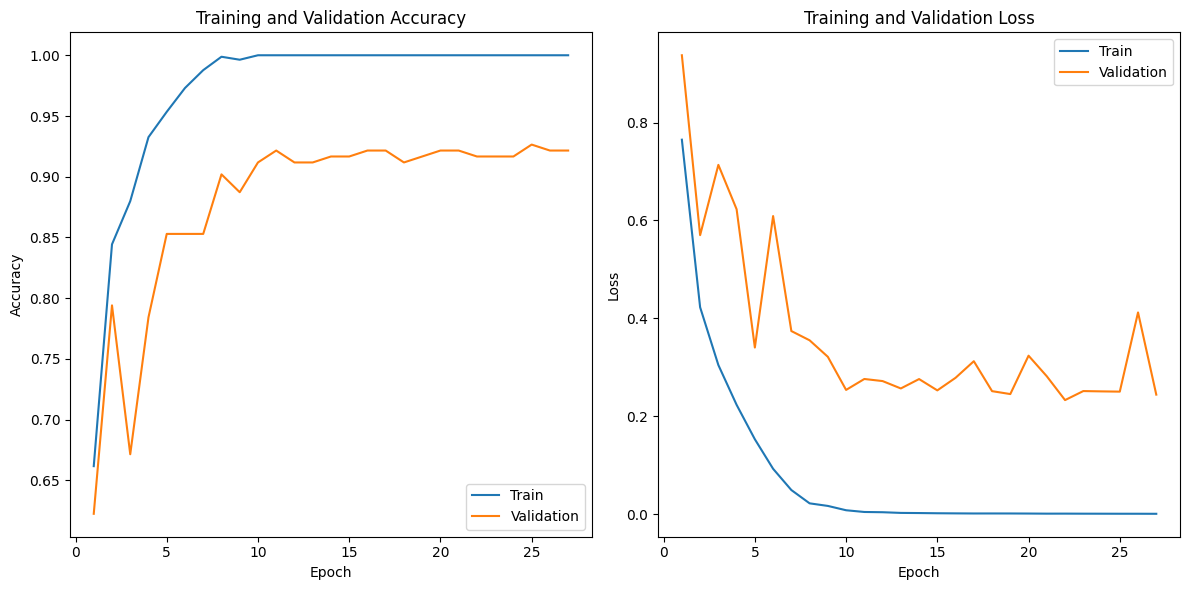

In [62]:
epochs = range(1, len(train_metrics['accuracy']) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_metrics['accuracy'], label='Train')
plt.plot(epochs, val_metrics['accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_metrics['loss'], label='Train')
plt.plot(epochs, val_metrics['loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Step 5 - Evaluate CNN

In [63]:
test_loss, test_accuracy, test_precision, test_recall, test_f1 = evaluate(
    model, test_loader, criterion, device, print_cf_report=True
)

print("\nTest Results:")
print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1-Score: {test_f1:.4f}")

              precision    recall  f1-score   support

           0       1.00      0.93      0.97        60
           1       0.97      1.00      0.98        60
           2       0.95      0.98      0.97        60

    accuracy                           0.97       180
   macro avg       0.97      0.97      0.97       180
weighted avg       0.97      0.97      0.97       180


Test Results:
Test Loss: 0.1643, Accuracy: 0.9722, Precision: 0.9731, Recall: 0.9722, F1-Score: 0.9721


## Step 6 - Retrieve LIME Explanation

In [64]:
def convert_tensor_to_np(tensor_image):
    np_image = tensor_image

    if type(np_image) != np.ndarray:
        np_image = np_image.cpu().numpy()
        np_image = np.transpose(np_image, (1, 2, 0))  # CHW to HWC

    return np_image

def convert_np_to_tensor(np_image):
    tensor_image = np_image

    if type(tensor_image) != torch.Tensor:
        tensor_image = torch.from_numpy(tensor_image).permute(0, 3, 1, 2)  # HWC to CHW
        tensor_image = tensor_image.float().to(device)
    
    if len(tensor_image.shape) == 3:   # Add batch dimension if a single image
        tensor_image = tensor_image.unsqueeze(0)

    return tensor_image

In [65]:
def predict(input_img):
    input_tensor = convert_np_to_tensor(input_img)
    
    with torch.no_grad():
        output = model(input_tensor)
        probas = torch.nn.functional.softmax(output, dim=1)
    
    return probas.cpu().numpy()

In [66]:
sample_images, sample_labels = next(iter(test_loader))

In [67]:
def lime_explain_image(lime_sample_image, lime_sample_label):
    lime_sample_image_np = convert_tensor_to_np(lime_sample_image)
    lime_sample_label = get_class_names_from_idxs(lime_sample_label)[0]

    lime_sample_pred_label = get_class_names_from_idxs(np.argmax(predict(lime_sample_image)))[0]


    plt.imshow(lime_sample_image_np)
    plt.title(f"Label: {lime_sample_label}, Predicted: {lime_sample_pred_label}")
    plt.axis('off')
    plt.show()

    model.eval()
    explainer = lime_image.LimeImageExplainer()

    explanation = explainer.explain_instance(
        lime_sample_image_np, 
        predict, 
        top_labels=N_CLASSES,
        hide_color=0, 
        num_samples=1000
    )

    fig, axes = plt.subplots(2, 2, figsize=(12, 12))

    # 1. LIME Explanation with Positive Contributions Only
    image, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=5,
        hide_rest=False
    )
    axes[0, 0].imshow(mark_boundaries(image / 2 + 0.5, mask))
    axes[0, 0].axis('off')
    axes[0, 0].set_title("LIME Explanation (Positive Only)")

    # 2. Positive and Negative Contributions
    image, mask = explanation.get_image_and_mask(
        label=explanation.top_labels[0],  # Label of interest
        positive_only=False,  # Show both positive and negative contributions
        num_features=10,  # Number of superpixels to highlight
        hide_rest=False
    )
    axes[0, 1].imshow(mark_boundaries(image / 2 + 0.5, mask))
    axes[0, 1].axis("off")
    axes[0, 1].set_title("Positive and Negative Contributions")

    # 3. Superpixel Importance Heatmap
    heatmap = np.zeros(mask.shape)
    for feature, weight in explanation.local_exp[explanation.top_labels[0]]:
        heatmap[mask == feature] = weight
    axes[1, 0].imshow(image / 2 + 0.5)
    axes[1, 0].imshow(heatmap, cmap=cm.jet, alpha=0.6)  # Overlay heatmap with transparency
    axes[1, 0].axis("off")
    axes[1, 0].set_title("Superpixel Importance Heatmap")

    # 4. Top 3 Contributing Superpixels
    image, mask = explanation.get_image_and_mask(
        label=explanation.top_labels[0],
        positive_only=True,
        num_features=3,  # Show only the top 3 influential superpixels
        hide_rest=True
    )
    axes[1, 1].imshow(mark_boundaries(image / 2 + 0.5, mask))
    axes[1, 1].axis("off")
    axes[1, 1].set_title("Top 3 Contributing Superpixels")

    # Adjust layout
    plt.tight_layout()
    plt.show()

    return explanation

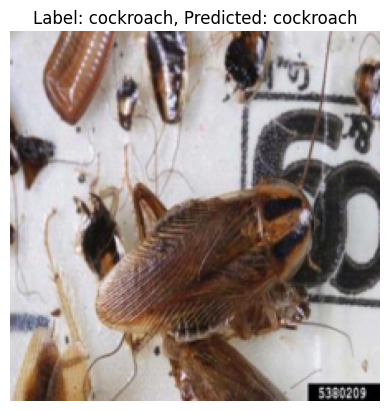

100%|██████████| 1000/1000 [00:08<00:00, 119.05it/s]


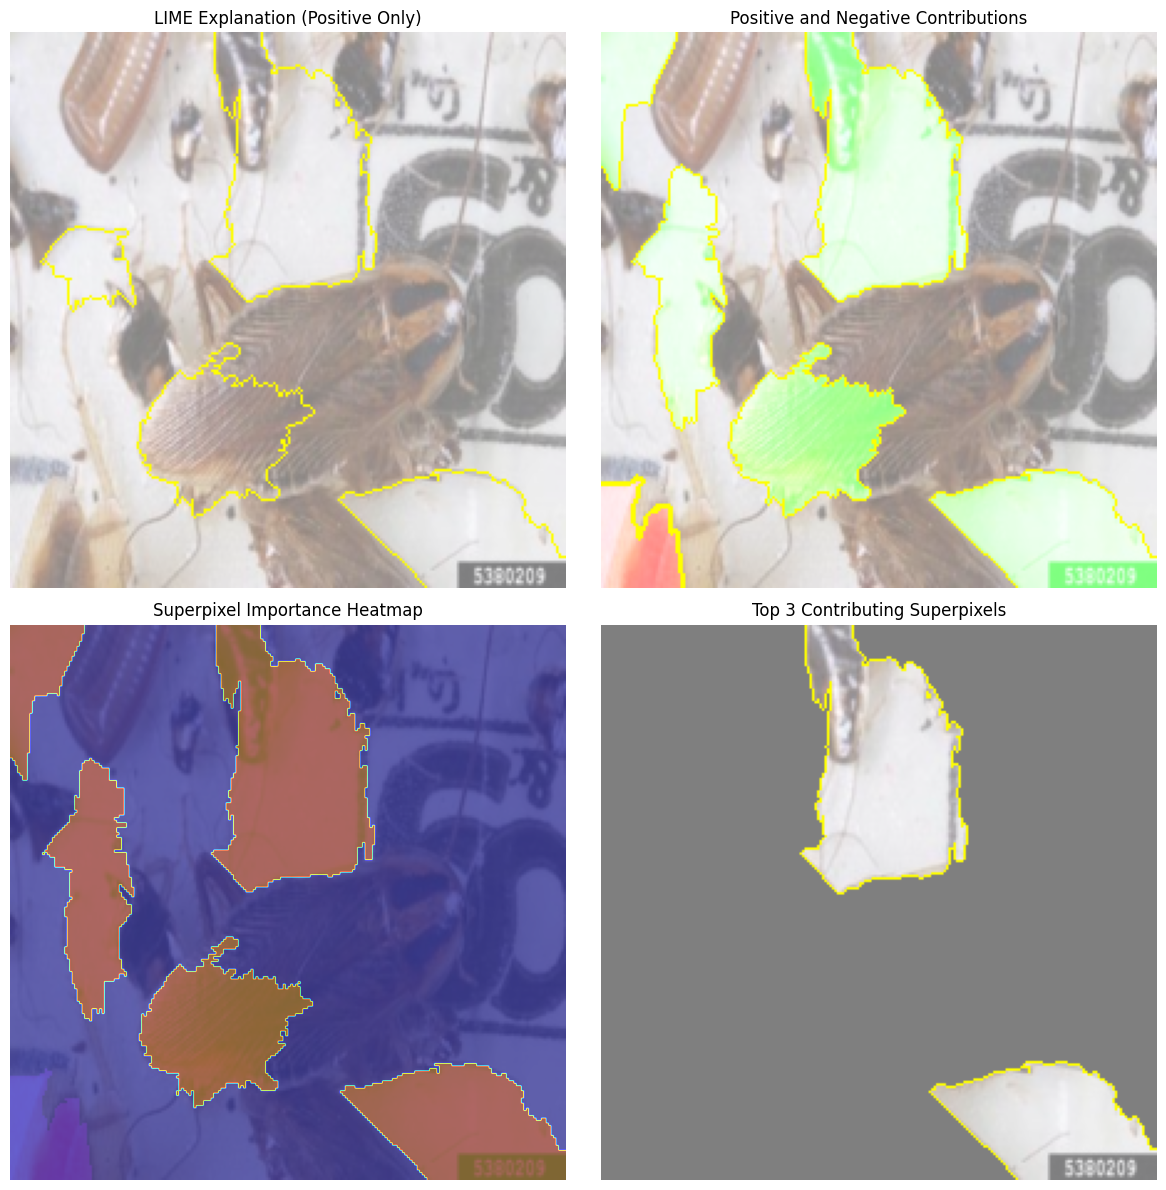

In [68]:
lime_explain_image(sample_images[0], sample_labels[0])

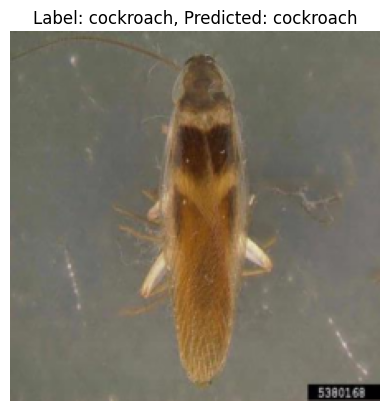

100%|██████████| 1000/1000 [00:10<00:00, 97.25it/s]


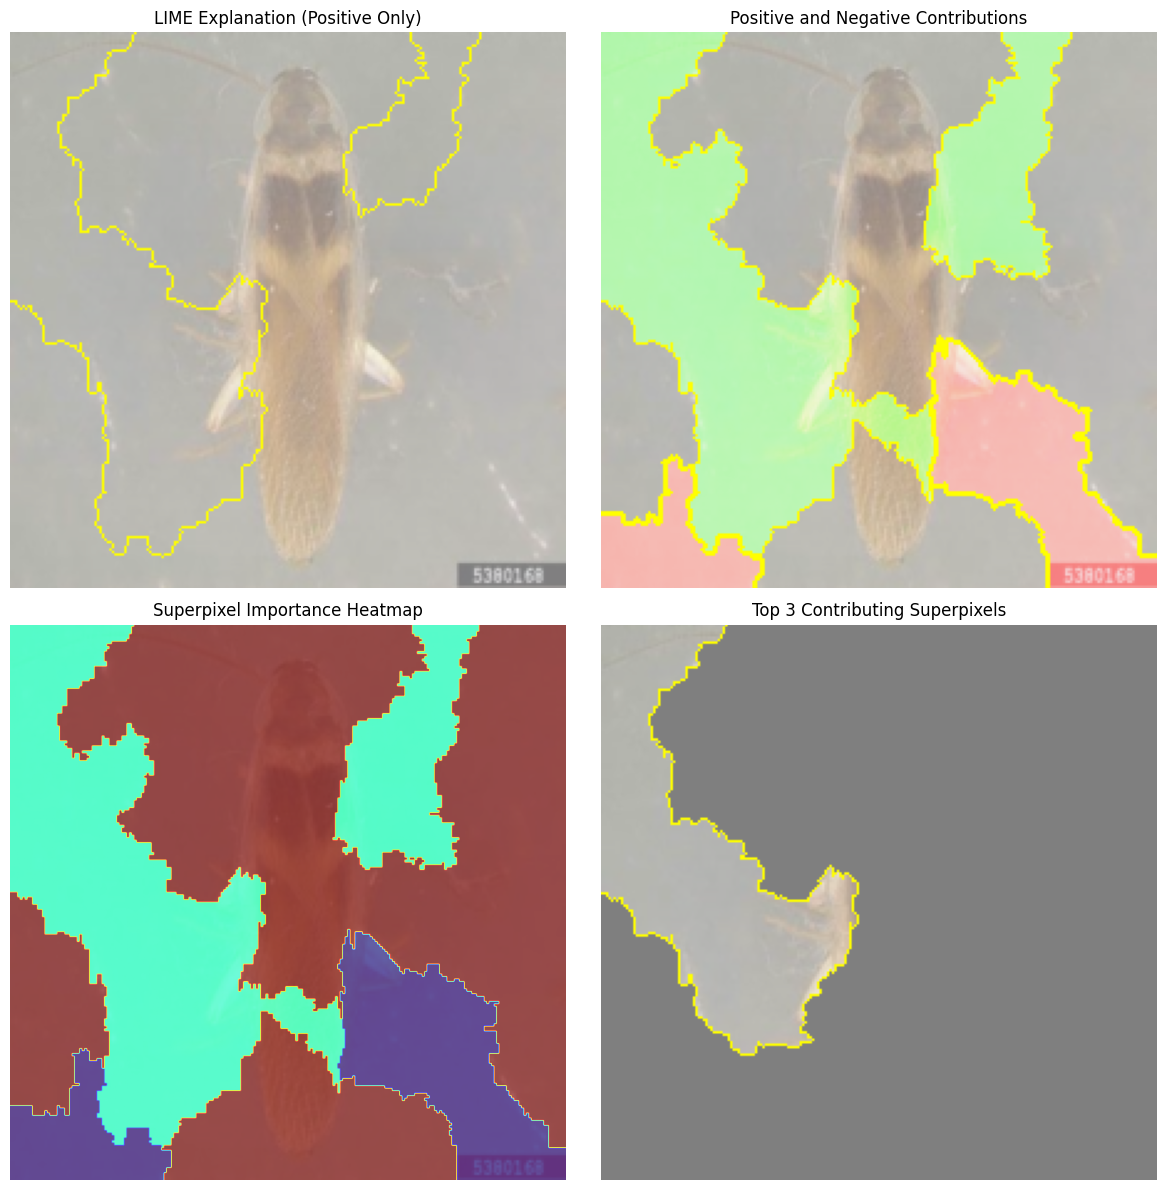

In [69]:
lime_explain_image(sample_images[2], sample_labels[2])

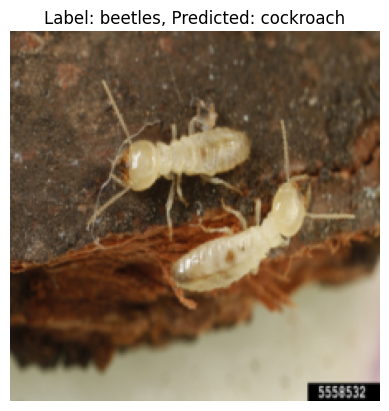

100%|██████████| 1000/1000 [00:13<00:00, 75.12it/s] 


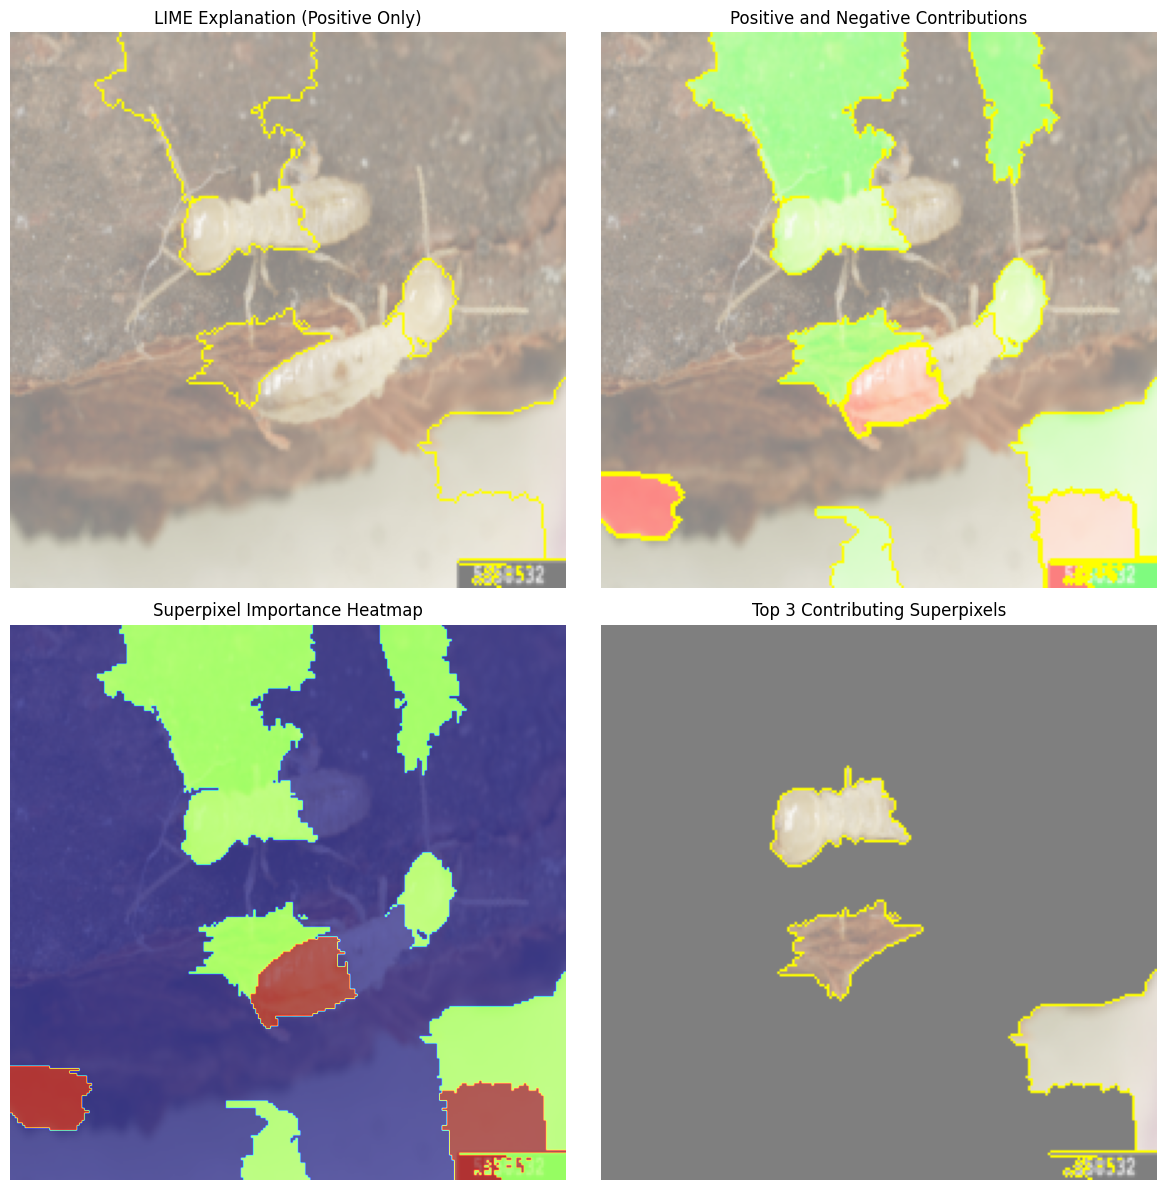

In [70]:
lime_explain_image(sample_images[3], sample_labels[3])

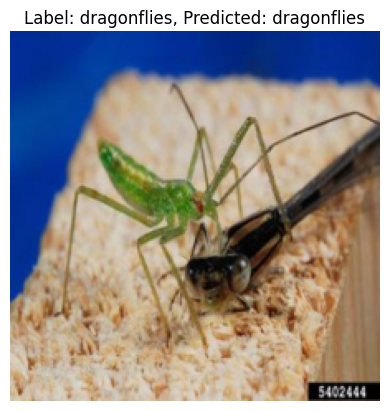

100%|██████████| 1000/1000 [00:10<00:00, 93.69it/s]


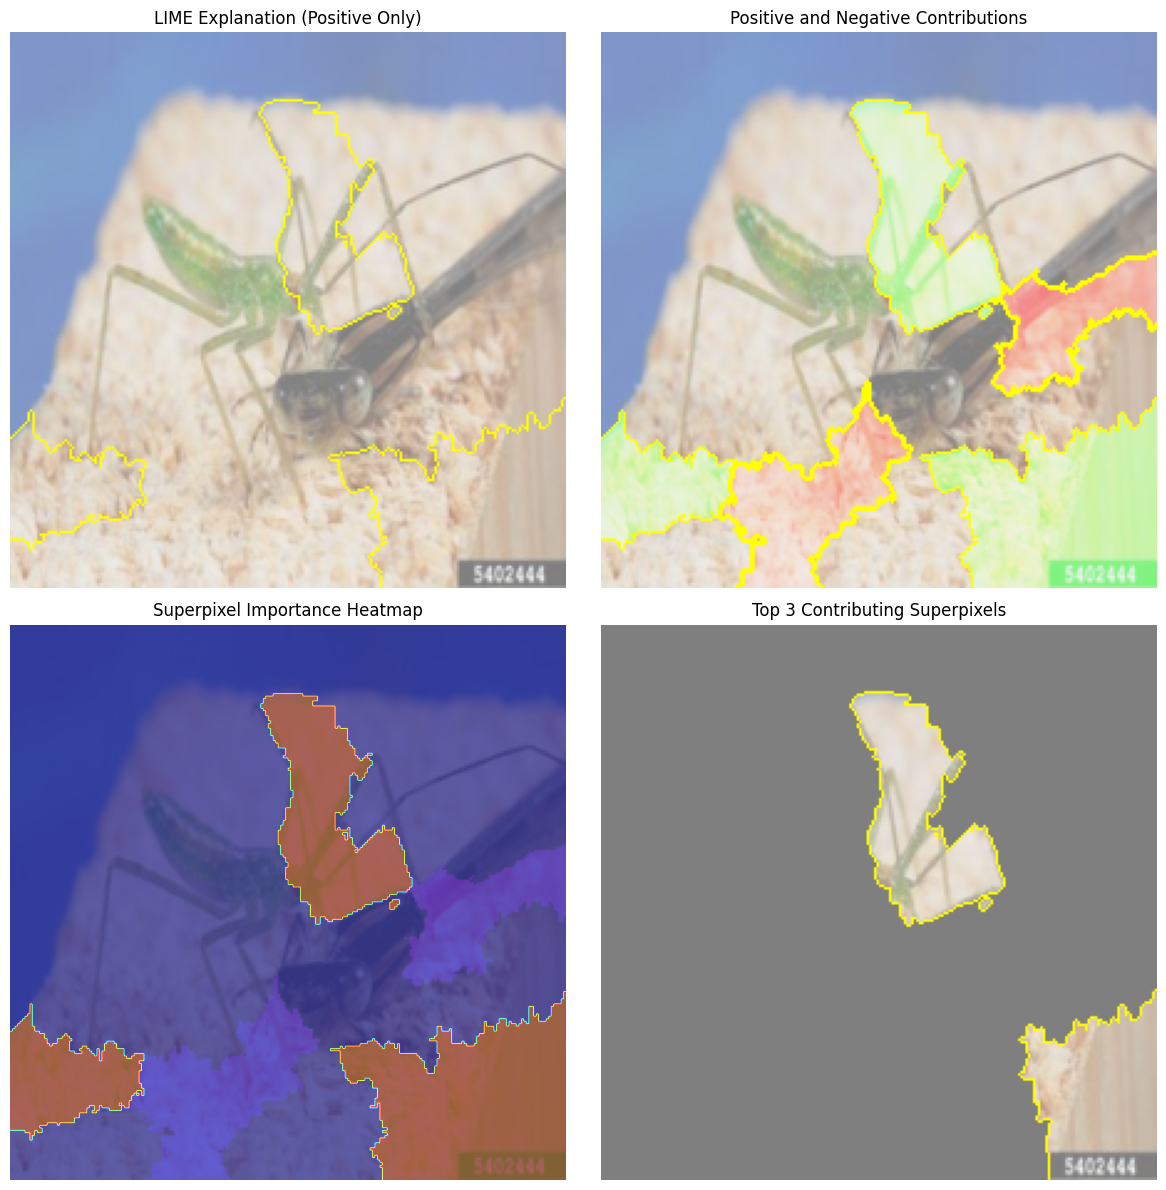

In [71]:
lime_explain_image(sample_images[5], sample_labels[5])

## Step 7 - Retrieve SHAP Explanation

In [72]:
shap_n_background_subset = 15
shap_n_test_subset = 5


shap_sample_background = sample_images[:shap_n_background_subset]
shap_sample_images = sample_images[shap_n_background_subset:shap_n_background_subset+shap_n_test_subset]
shap_test_labels = sample_labels[shap_n_background_subset:shap_n_background_subset+shap_n_test_subset]
shap_test_labels = get_class_names_from_idxs(shap_test_labels)

In [73]:
e = shap.DeepExplainer(model, shap_sample_background)

In [74]:
shap_values = e.shap_values(shap_sample_images)

In [75]:
shap_numpy = list(np.transpose(shap_values, (4, 0, 2, 3, 1)))
test_numpy = np.swapaxes(np.swapaxes(shap_sample_images.numpy(), 1, -1), 1, 2)

In [76]:
labels = [CLASS_NAMES] * shap_n_test_subset
labels_array = np.array(labels)
labels_array

array([['beetles', 'cockroach', 'dragonflies'],
       ['beetles', 'cockroach', 'dragonflies'],
       ['beetles', 'cockroach', 'dragonflies'],
       ['beetles', 'cockroach', 'dragonflies'],
       ['beetles', 'cockroach', 'dragonflies']], dtype='<U11')

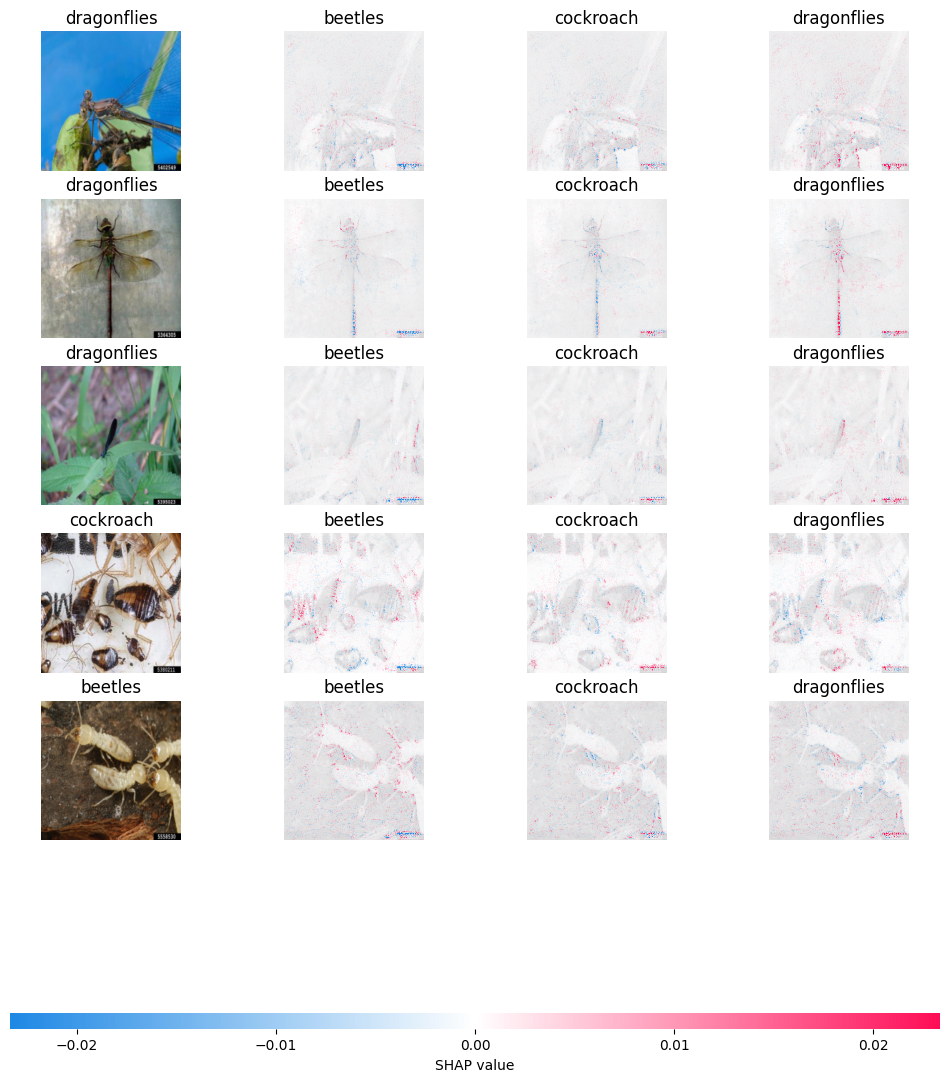

In [77]:
shap.plots.image(shap_numpy, test_numpy, labels=labels_array, true_labels=shap_test_labels)